In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch

25211
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

cmap_matrix = 'bwr'

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


path_save_ = "./jupyter-notebooks/NL/results/"

In [3]:
for _ in range(30):
    plt.close()

In [4]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - x* (x**2 - 0.25)

# t_max, x_max, x_center = 4.0, 1, -0.8
# x_centers_ = [- x_center, x_center, 0.5*x_center, - 0.5*x_center] 

# t_max, x_max, x_center = 4.0, 1, 0.125
# x_centers_ = [- x_center, x_center, 6.*x_center, - 6.*x_center] 

t_max, x_max, x_center = 4.0, 1, 0.25
x_centers_ = [- x_center, x_center, 3.*x_center, - 3.*x_center] 
# ----------------------------------------

flag_sim_ = True # if False, then only plot the resulting matrices;

if flag_sim_:
    nx, nt = 7, 11  # for simulations
else:
    nx, nt = 4, 11  # for plotting

Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-x_max, x_max, Nx)
t = np.linspace(0,t_max,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

# ------------------------------------------------------
psi_init_ = np.zeros(Nx, dtype=float)
delta_gauss = 0.05
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_init_[ii] = 0
    for i_center in range(len(x_centers_)):
        psi_init_[ii] += np.exp(-(x[ii] + x_centers_[i_center])**2/(2.*delta_gauss**2)) 
psi_init_[0] = 0
psi_init_[Nx-1] = 0
del ii


print("nx: {:d}".format(nx))
print("nt: {:d}".format(nt))
print("sum psi**2: {:0.3e}".format(np.trapz(psi_init_**2, dx=dx)))

sol_ref_several = []


nx: 7
nt: 11
sum psi**2: 3.545e-01


<IPython.core.display.Javascript object>


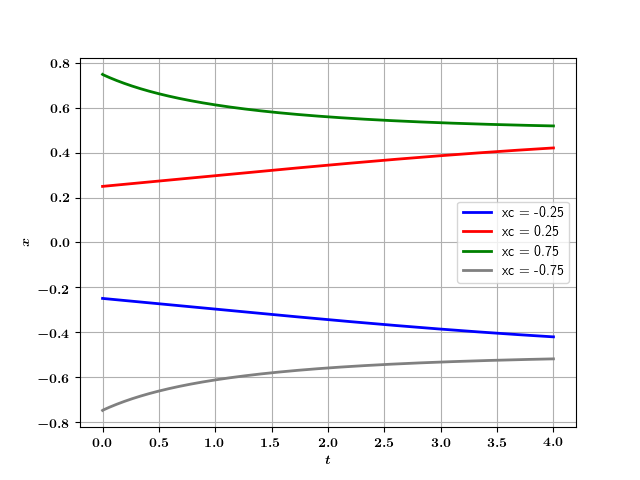

In [5]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

def solve_standart(x_center_ref):
    oo = RK45(
        lambda t,x: F_(x), 
        t[0], 
        [x_center_ref], t[-1], first_step=dt, max_step=dt
    )
    
    sol_ref = np.zeros(Nt, dtype=float)
    sol_ref[0] = x_center_ref
    Nt_act = 1
    
    oo.step()
    oo.t
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        if Nt_act - 1 == Nt:
            print(oo.t)
        sol_ref[Nt_act-1] = float(oo.y[0])
    return sol_ref
# --------------------------------------------------------------------------

if flag_sim_:
    sol_refs = []
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i_center in range(len(x_centers_)):
        x_center = x_centers_[i_center]
    
        # --- Solve for the particular x_center ---
        sol_one = solve_standart(x_center)
        sol_refs.append(sol_one)
    
        # --- Plotting ---
        ax.plot(
            t, sol_one, 
            color=colors_[i_center], linewidth = 2, linestyle='-', 
            label = "xc = {:0.2f}".format(x_center)
        )
        del x_center
    plt.xlabel('$t$')
    plt.ylabel("$x$")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Simulations are blocked.")

In [6]:
# --------------------------------------------------------------------------------
# --- Form the KvN Hamiltonian ---
# --------------------------------------------------------------------------------
mix.reload_module(kvn)

print("--- CENTRAL DIFFERENCE SCHEME ---")
H_CD     = kvn.construct_UW_matrix_1D(x, F_)
kvn.is_Hermitian(H_CD, "CD")

print("--- UPWINDING DIFFERENCE SCHEME ---")
H_UW     = kvn.construct_UW_matrix_1D(x, F_)
kvn.is_Hermitian(H_UW, "UW")

--- CENTRAL DIFFERENCE SCHEME ---
the matrix CD is non-Hermitian
--- UPWINDING DIFFERENCE SCHEME ---
the matrix UW is non-Hermitian


In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [7]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the KvN Hamiltonian ---
# --------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
from numba import njit
import time

# --- computation ---
if flag_sim_:
    st = time.time()
    
    psi_tx_matrix_CD   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_CD)
    psi_tx_matrix_UW   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx, psi_init_, H_UW)
    
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    # --- Compute the mean value ---
    mean_t_CD   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_CD)
    mean_t_UW   = kvn.compute_mean_1D(x, Nt, psi_tx_matrix_UW)
else:
    print("Simulations are blocked.")

Execution time: 0.5120010375976562 seconds


<IPython.core.display.Javascript object>


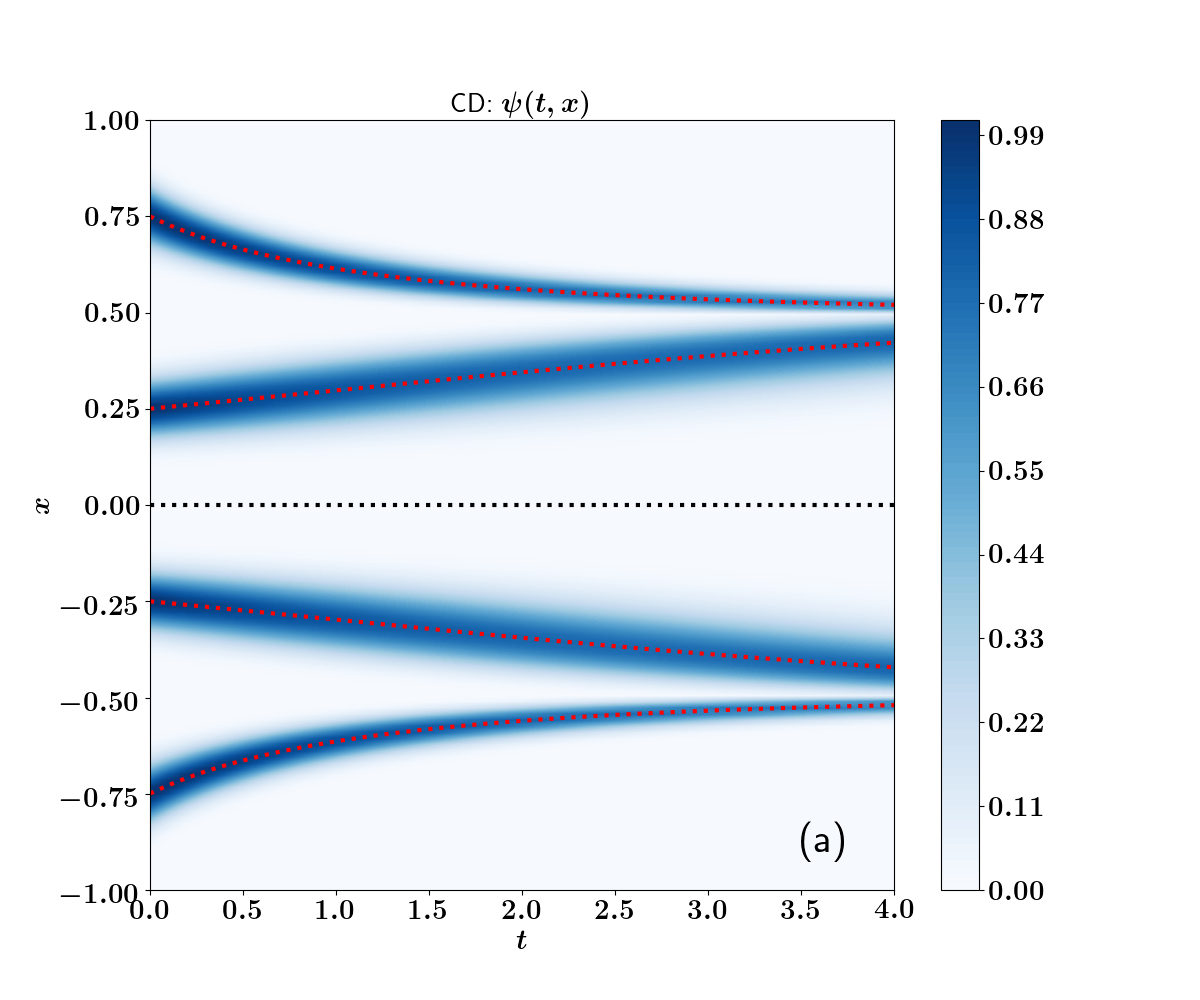

In [7]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi_tx_matrix(t,x) ---
# ---------------------------------------------------------------------------------------------------
if flag_sim_:
    psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_CD, mean_t_CD, "CD: ", "(a)"
    # psi_tx_plot, mean_t_plot, str_title, str_fig = psi_tx_matrix_UW, mean_t_UW, "UW: ", "(b)"
    
    fontsize = 20
    
    # --- Plotting ---
    XX, YY = np.meshgrid(t, x)
    fig_tx = plt.figure(figsize=(12, 10))
    ax = fig_tx.add_subplot(111)
    cs = ax.contourf(XX, YY, np.transpose(psi_tx_plot.real), levels=100, cmap=cmap_two_signs_)
    
    # cb = fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    cb = fig_tx.colorbar(cs, ax = ax)
    cb.ax.ticklabel_format(style="scientific")
    cb.ax.tick_params(labelsize=fontsize) 
    
    ax.plot(t, mean_t_plot, color='black', linewidth = 3.0, linestyle=':', label="mean")
    
    ax.plot(t, sol_refs[0], color='r', linewidth = 3.0, linestyle=':', label="ref")
    for i_ref in range(1,len(sol_refs)):
        ax.plot(t, sol_refs[i_ref], color='r', linewidth = 3.0, linestyle=':')
    
    # ax.legend()
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_ylabel('$x$', fontsize = fontsize)
    ax.set_title(str_title + '$\psi(t,x)$', fontsize = fontsize)
    ax.set_xlim(0, t_max)
    ax.set_ylim(-x_max, x_max)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(3.5, -0.9, str_fig, fontsize=1.5*fontsize)
    
    del fontsize, fig_tx
else:
    print("Simulations are blocked.")

<IPython.core.display.Javascript object>


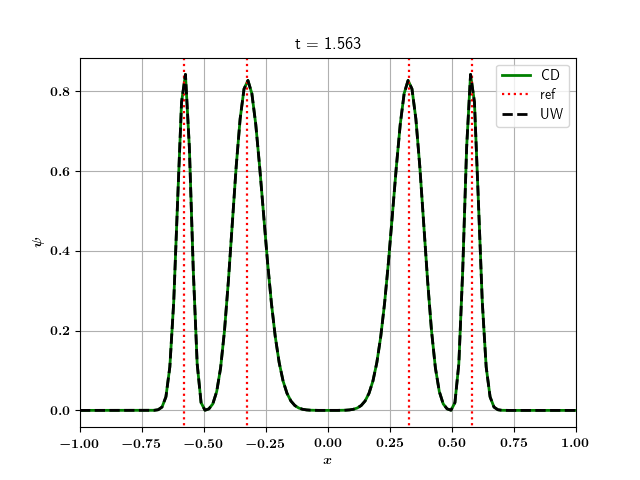


--- reference points ---
-3.247e-01
3.247e-01
5.789e-01
-5.789e-01

chosen time moment: 1.563


In [9]:
# ---------------------------------------------------------------------------------------------------
# --- Plot psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------

flag_save = False
fname_CD = "CD_x_t1.dat"
fname_UW = "UW_x_t1.dat"
idt_moment = 160*5

# ------------------------------------------------------------
if flag_sim_:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x, psi_tx_matrix_CD.real[idt_moment,:], 
        color="green", linewidth = 2.0, linestyle='-',
        label = "CD"
    )
    ax.axvline(
        sol_refs[0][idt_moment], 
        ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
        color = "r", linewidth = 1.6, linestyle = ":",
        label = "ref"
    )
    for i_center in range(1, len(sol_refs)):
        ax.axvline(
            sol_refs[i_center][idt_moment], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":"
        )
    ax.plot(
        x, psi_tx_matrix_UW.real[idt_moment,:], 
        color="black", linewidth = 2.0, linestyle='--',
        label = "UW"
    )
    plt.xlim([-x_max,x_max])
    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    plt.title("t = {:0.3f}".format(t[idt_moment]))
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Save the 1D data ---
    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_CD, 
            x, 
            psi_tx_matrix_CD.real[idt_moment,:]
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/" + fname_UW, 
            x, 
            psi_tx_matrix_UW.real[idt_moment,:]
        )
    # --- Print the reference points ---
    print("\n--- reference points ---")
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][idt_moment]))
    print()
    print("chosen time moment: {:0.3f}".format(t[idt_moment]))
else:
    print("Simulations are blocked.")

del idt_moment, flag_save, fname_CD, fname_UW

In [ ]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [20]:
# ----------------------------------------------------------------------
# --- LCHS simulation (in python) ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
def LCHS_py(kmax, nk, ids_t_LCHS_py):
    print()
    print("--- Case: kmax = {:0.1f}, nk = {:d}".format(kmax, nk))

    # --- k-grid ---
    k_grid     = np.linspace(- kmax, kmax, 1 << nk)

    # --- computation ---
    psi_LCHS_py = np.zeros((len(ids_t_LCHS_py), Nx), dtype = complex)
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]
        print("LCHS at t = {:0.3e}".format(t[id_t_LCHS_py]))
        psi_LCHS_py[counter_t, :] = kvn.LCHS_computation(
            k_grid, dt,
            1.j*H_UW, psi_init_, id_t_LCHS_py, 
            flag_trotterization = True, 
            flag_print = False
        )
    print("Done.")
    
    # save results:
    dd = {
        "psi": psi_LCHS_py,
        "nk": nk,
        "kmax": kmax
    }
    return dd

def gkL(kmax, nk):
    return format("{:0.1f} {:d}".format(kmax, nk))
# ------------------------------------------------------------------------

# time points where the LCHS statevector is calculated: 
ids_t_LCHS_py = [
    Nt//3, 
    Nt//2, 
    Nt//10*9
]
dds_LCHS_py = {}

kmax, nk = 10., 5
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 10., 7
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 10., 8
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 20., 8
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)

kmax, nk = 40., 9
dds_LCHS_py[gkL(kmax, nk)] = LCHS_py(kmax, nk, ids_t_LCHS_py)


--- Case: kmax = 20.0, nk = 8
LCHS at t = 1.333e+00
LCHS at t = 2.001e+00
LCHS at t = 3.588e+00
Done.

--- Case: kmax = 40.0, nk = 9
LCHS at t = 1.333e+00
LCHS at t = 2.001e+00
LCHS at t = 3.588e+00
Done.


In [25]:
# ----------------------------------------------------------------------
# --- Plot results from the python LCHS simulation ---
# ----------------------------------------------------------------------
def plot_LCHS_py(dds):
    for counter_t in range(len(ids_t_LCHS_py)):
        id_t_LCHS_py = ids_t_LCHS_py[counter_t]

        print()
        print("chosen time moment: {:0.3f}".format(t[id_t_LCHS_py]))
        
        colors_loc = ["green", "blue", "black", "magenta"]
        line_styles = ["-", "--", "--"]

        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        for ii in range(len(dds)):
            ax.plot(
                x, 
                dds[ii]["psi"].real[counter_t, :], 
                color=colors_loc[ii], 
                linewidth = 2.0, 
                linestyle=line_styles[ii],
                label = "kmax = {:0.1f}, nk = {:d}".format(
                    dds[ii]["kmax"], dds[ii]["nk"]
                )
            )
        
        ax.axvline(
            sol_refs[0][id_t_LCHS_py], 
            ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
            color = "r", linewidth = 1.6, linestyle = ":",
            label = "ref"
        )
        for i_center in range(1, len(sol_refs)):
            ax.axvline(
                sol_refs[i_center][id_t_LCHS_py], 
                ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1]*2, 
                color = "r", linewidth = 1.6, linestyle = ":"
            )
        plt.xlim([-x_max,x_max])
        plt.xlabel('$x$')
        plt.ylabel("$Re[\psi]$")
        plt.title("t = {:0.3f}".format(t[id_t_LCHS_py]))
        plt.grid(True)
        plt.legend()
        plt.show()

    
def save_LCHS_py(kmax, nk, fname_LCHS_py, counter_t):
    fname = "{:s}{:d}_k{:d}_n{:d}.dat".format(
        fname_LCHS_py, counter_t, int(kmax), nk
    )
    mix.save_dat_plot_1d_file(
        path_save_ + "/" + fname, 
        x, 
        dds_LCHS_py[gkL(kmax, nk)]["psi"].real[counter_t,:]
    )
    
    
# -----------------------------------------------------------------------------------------
    
    
flag_save = False
flag_plot = False

# kmax_plot, nk_plot = [10, 10, 10], [5, 7, 8]
kmax_plot, nk_plot = [10, 20, 40], [7, 8, 9]


# --- Plotting ---
if flag_plot:
    dds_plot = [
        dds_LCHS_py[gkL(kmax_plot[0], nk_plot[0])],
        dds_LCHS_py[gkL(kmax_plot[1], nk_plot[1])],
        dds_LCHS_py[gkL(kmax_plot[2], nk_plot[2])]
    ]
    plot_LCHS_py(dds_plot)
    
# --- Print reference peaks ---
print()
for counter_t in range(len(ids_t_LCHS_py)):
    id_t_LCHS_py = ids_t_LCHS_py[counter_t]
    print("--- t{:d} = {:0.3f} ---".format(
        counter_t, t[id_t_LCHS_py]
    ))
    for i_center in range(len(sol_refs)):
        print("{:0.3e}".format(sol_refs[i_center][id_t_LCHS_py]))

# --- Save the 1D data ---
if flag_save:
    print()
    fname_LCHS_py = "LCHS_py_x_t"
    for counter_t in range(len(ids_t_LCHS_py)):
        save_LCHS_py(kmax_plot[0], nk_plot[0], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[1], nk_plot[1], fname_LCHS_py, counter_t)
        save_LCHS_py(kmax_plot[2], nk_plot[2], fname_LCHS_py, counter_t)

del flag_save


--- t0 = 1.333 ---
-3.138e-01
3.138e-01
5.913e-01
-5.913e-01
--- t1 = 2.001 ---
-3.449e-01
3.449e-01
5.604e-01
-5.604e-01
--- t2 = 3.588 ---
-4.085e-01
4.085e-01
5.248e-01
-5.248e-01


In [8]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************

In [9]:
# ----------------------------------------------------------
# --- Parameters for the LCHS simulation ---
# ----------------------------------------------------------
mix.reload_module(kvn)

# --- LCHS parameters ---
nk_    = 5
k_max_ = 10

# - k-grid -
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]


# --- Find Hermitian and anti-Hermitian parts:
Ah_, Aa_ = kvn.get_herm_aherm_parts(1j * H_UW)

# --- LCHS matrices ---
Ba     = Aa_
B_kmax = - k_max_ * Ah_
Bk     =      dk_ * Ah_

# --- Normalize the matrices ---
Ba_norm_, ncoef_a_, nonsparsity_a_           = kvn.compute_normalized_matrix(Ba, "Ba")
B_kmax_norm_, ncoef_kmax_, nonsparsity_kmax_ = kvn.compute_normalized_matrix(B_kmax, "B_kmax")
Bk_norm_, ncoef_k_, nonsparsity_k_           = kvn.compute_normalized_matrix(Bk, "Bk")
print()
print("norm of Ba_norm_:     {:0.3f}".format(kvn.find_norm_of_matrix(Ba_norm_)))
print("norm of B_kmax_norm_: {:0.3f}".format(kvn.find_norm_of_matrix(B_kmax_norm_)))
print("norm of Bk_norm_:     {:0.3f}".format(kvn.find_norm_of_matrix(Bk_norm_)))


>>> Matrix Ba
nonsparsity, coefnorm: 2, 6.359e+01

>>> Matrix B_kmax
nonsparsity, coefnorm: 3, 1.651e+03

>>> Matrix Bk
nonsparsity, coefnorm: 3, 1.065e+02

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333


In [12]:
# ---------------------------------------
# --- Plot the original matrices ---
# ---------------------------------------
mix.reload_module(kvn)

if not flag_sim_:
    flag_save = False
    path_save = "./jupyter-notebooks/NL/results"
    
    # matrix_labels = ["", "", ""]
    matrix_labels = ["(a)", "(b)", "(c)"]
    
    kvn.plot_A_structure(
        H_UW, "\mathcal{H}^{UW}",
        matrix_labels[0], "fig_x2_H",
        flag_save = flag_save, 
        path_save = path_save
    )
    kvn.plot_A_structure(
        Ah_, "A_h",
        matrix_labels[1], "fig_x2_Ah",
        flag_save = flag_save, 
        path_save = path_save
    )
    kvn.plot_A_structure(
        Aa_, "A_a",
        matrix_labels[2], "fig_x2_Aa",
        flag_save = flag_save, 
        path_save = path_save
    )
else:
    print("Plotting of matrices is blocked.")

Plotting of matrices is blocked.


<IPython.core.display.Javascript object>


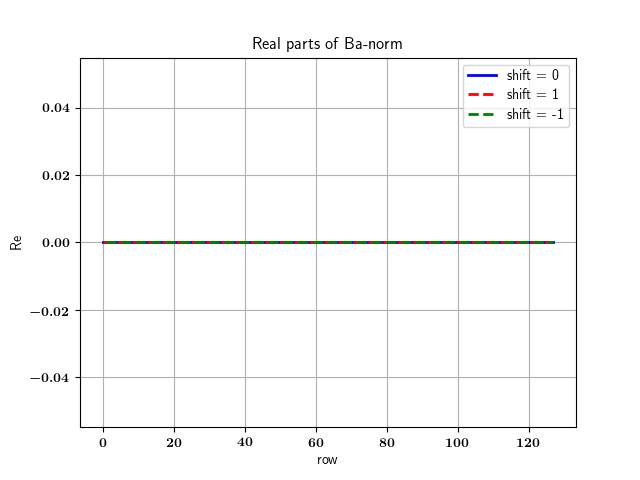

<IPython.core.display.Javascript object>


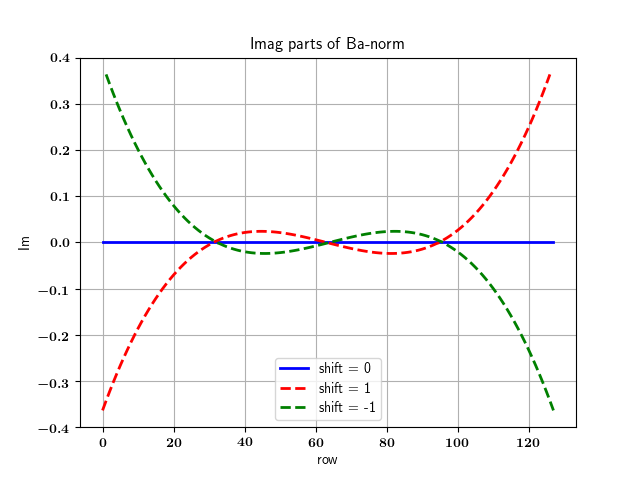

In [16]:
# ---------------------------------------------------------
# --- Print diagonals from matrices ---
# ---------------------------------------------------------
mix.reload_module(kvn)


A_plot, A_name = Ba_norm_, "Ba-norm"
# A_plot, A_name = B_kmax_norm_, "B-kmax-norm"
# A_plot, A_name = Bk_norm_, "Bk-norm"
# A_plot, A_name = Ah_, "Ah"
# A_plot, A_name = Aa_, "Aa"

sh_1 = 0
diag_1, rows_1 = kvn.get_diag(A_plot, i_shift = sh_1)

sh_2 = 1
diag_2, rows_2 = kvn.get_diag(A_plot, i_shift = sh_2)

sh_3 = -1
diag_3, rows_3 = kvn.get_diag(A_plot, i_shift = sh_3)


# --- Real parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.real, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.real, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.real, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Re")
plt.title("Real parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

# --- Imaginery parts ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rows_1, diag_1.imag, color='b', linewidth = 2, linestyle='-', label = "shift = {:d}".format(sh_1))
ax.plot(rows_2, diag_2.imag, color='r', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_2))
ax.plot(rows_3, diag_3.imag, color='g', linewidth = 2, linestyle='--', label = "shift = {:d}".format(sh_3))
plt.xlabel('row')
plt.ylabel("Im")
plt.title("Imag parts of {:s}".format(A_name))
plt.legend()
plt.grid(True)
plt.show()

Chosen profile: Ba-normsh1
Chosen parity: 1

Minimization method is used.
Computation status:  3.8051594371417973e-06

Chosen polynomial's degree:	 90
Number of coefficients:		 45
max. abs. error: 6.989e-04


<IPython.core.display.Javascript object>


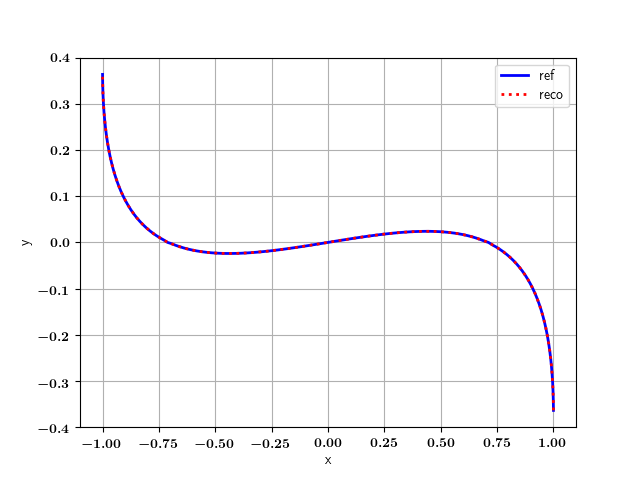

In [20]:
# --------------------------------------------------------------------------------------
# --- Compute the Chebyschev coefficients for the QSVT computations of the BE oracle ---
# --------------------------------------------------------------------------------------
mix.reload_module(ch)
mix.reload_module(kvn)

# --- Choose the matrix and the diagonal ---
A_chosen, A_name, flag_real, parity_1 = Ba_norm_, "Ba-norm", False, 1          # >>> depends on Aa 
# A_chosen, A_name, flag_real, parity_1 = B_kmax_norm_, "B-kmax-norm", True, 0  # >>> depends on Ah
# A_chosen, A_name, flag_real, parity_1 = Bk_norm_, "Bk-norm", True, 0          # >>> depends on Ah

# --- Choose the diagonal ---
sh_1 = 1


diag_ch, rows_ch = kvn.get_diag(A_chosen, i_shift = sh_1)
if flag_real:
    diag_ch = diag_ch.real
else:
    diag_ch = diag_ch.imag


# --- Form the name of the investigated profile:
name_prof_1 = A_name + "sh{:d}".format(sh_1)

# --- Parameters for the computation of the Chebyschev coefficients ---
sel_method = 0
Nd = 90

# --- Computation ---
oo_ch_ = ch.Ch_()
oo_ch_.choose_method(sel_method)
oo_ch_.choose_func(
    -1, None, 
    profile_in = diag_ch.real,
    name_prof  = name_prof_1,
    parity_in  = parity_1,
    path_root_in = "./jupyter-notebooks/NL/BE/coefs/"
)
oo_ch_.compute_Ch(Nd)
oo_ch_.plot_reconstructed_function()

<IPython.core.display.Javascript object>


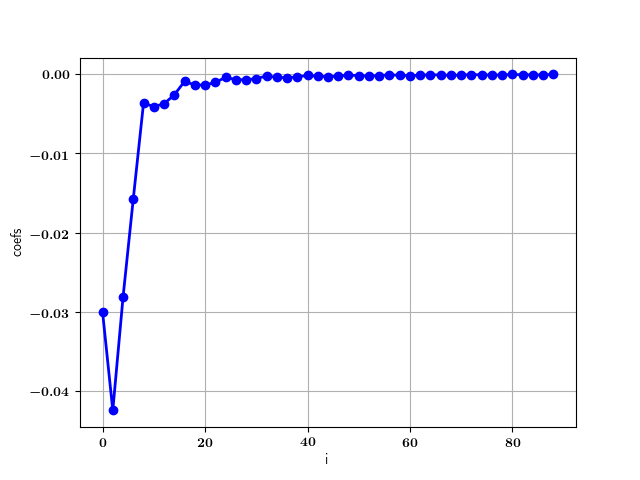

In [14]:
# ----------------------------------------------------
# --- Plot Chebyschev coefficients for the BE oracle ---
# ----------------------------------------------------
oo_ch_.plot_coefficients()